# Exploration: Undestanding the opioid crisis with a modified epidemic model



This notebook contains model and data exploration. While these methods were all incorporated into the project, the notebook does not contain the final models, parameters, and analysis used for the paper results.

----

### Imports

In [19]:
import numpy as np
import pandas as pd
import scipy as sp
import time
pd.set_option('display.max_rows', 999)
pd.set_option('display.width', 500)
pd.set_option('display.notebook_repr_html', True)
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
%matplotlib inline

### The system of equations

In [20]:
def opioid(state, t, alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star):
    S, P, A, R = state
    S_prime = -alpha*S - beta*(1-xi)*S*A - beta*xi*S*P + epsilon*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (epsilon + gamma + mu)*P
    A_prime = gamma*P + sigma*R + beta*(1-xi)*S*A + beta*xi*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    return [S_prime, P_prime, A_prime, R_prime]

### Our modified version

In [21]:
def opioid_modified(state, t, alpha, beta, xi, gamma, zeta, nu, sigma, mu, mu_star):
    S, P, A, R = state
    delta = 1 - sigma - nu*A
    S_prime = -alpha*S - beta*(1-xi)*S*A - beta*xi*S*P + epsilon*P + delta*R + mu*(P+R) + mu_star*A
    P_prime = alpha*S - (epsilon + gamma + mu)*P
    A_prime = gamma*P + sigma*R + beta*(1-xi)*S*A + beta*xi*S*P + nu*R*A - (zeta + mu_star)*A
    R_prime = zeta*A - nu*R*A - (delta + sigma + mu)*R
    return [S_prime, P_prime, A_prime, R_prime]

### Try initial parameters

In [22]:
# parameters
epsilon = 0.74 # Prescribed to Susceptible rate
xi = 0.505 #  fraction of beta due to P
gamma = 0.26 # rate of addiction among prescribed users
epsilon = 1 - gamma
nu = 0.2 # relapse rate of R due to A pressure
#nu = 10 # what I think it should be

sigma = 0.7 # natural relapse rate of R 
mu = 0.00824 # death rate
mu_star = 0.00834 # death rate of addicts

delta = 0.1 # Recovering to Susceptible rate. 0.1 is default
beta = 0.0625 # total addiction rate for Susceptible class due to illegal access

alpha = 0.1 # prescription rate. could be 0-1
zeta = 0.5 # rate of A entry into rehab. could be 0-1

# Do we need to enforce sigma + nu + delta = 1?
# Do we need to enforce epsilon + gamma = 1

print (epsilon + gamma)
sigma + nu + delta

1.0


0.9999999999999999

### 1. Solve the system of ODEs using forward Euler

In [23]:
# times to solve at
t = np.linspace(0, 50, 1000)

# initial state
state0 = [0.88, 0.1, 0.01, 0.01]
dt = 0.05
spar_current = state0
spars = [state0]
for n in range(1,len(t)):
    slope = np.array(opioid(spar_current, t, alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))
    spar_next = spar_current + dt*slope
    spar_current = spar_next
    spars.append(spar_next)
print "Final addiction rate", spar_current[2]

Final addiction rate 0.257193875535


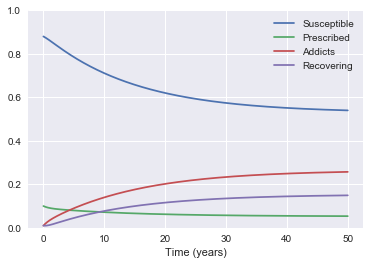

In [24]:
spars = np.array(spars)
S = spars[:,0]
P = spars[:,1]
A = spars[:,2]
R = spars[:,3]

plt.plot(t, S, label="Susceptible")
plt.plot(t, P, label="Prescribed")
plt.plot(t, A, label="Addicts")
plt.plot(t, R, label="Recovering")
plt.xlabel("Time (years)")
plt.ylim([0, 1])
plt.legend()

### 2. Solve using odeint

('Final addiction rate', 0.25739279318601682)


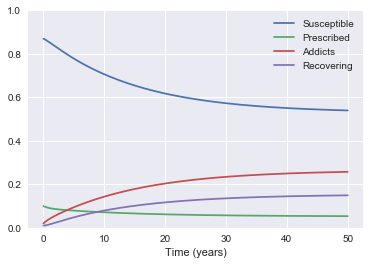

In [25]:
# times to solve at
t = np.linspace(0, 50, 1000)

# initial state
state0 = [0.87, 0.1, 0.02, 0.01]

numerical_sol = sp.integrate.odeint(opioid, state0, t, args=(alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))

S = numerical_sol[:,0]
P = numerical_sol[:,1]
A = numerical_sol[:,2]
R = numerical_sol[:,3]

plt.plot(t, S, label="Susceptible")
plt.plot(t, P, label="Prescribed")
plt.plot(t, A, label="Addicts")
plt.plot(t, R, label="Recovering")
plt.xlabel("Time (years)")
plt.ylim([0, 1])
plt.legend()
print("Final addiction rate", A[-1])
#plt.plot(t, population_us*(mu_star-mu)*A)
#plt.plot(t, P, label= "prescribed")
#population_us = 320000000. 

Our equilibrium solutions for forward Euler and odeint are very similar.

### Check that the population is constant

In [26]:
(S+P+A+R)[-100:-1]

array([ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.])

## Sensitivity analysis exploration

### Explore Sobol analysis

In [27]:
from SALib.sample import saltelli
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np

# Fake example
problem = {
  'num_vars': 3,
  'names': ['x1', 'x2', 'x3'],
  'bounds': [[-np.pi, np.pi]]*3
}

# Generate samples
param_values = saltelli.sample(problem, 1000, calc_second_order=True)

# Run model (example)
Y = Ishigami.evaluate(param_values)

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=False)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)

Si

{'S1': array([ 0.30797549,  0.44776661, -0.00425452]),
 'S1_conf': array([ 0.07304636,  0.05077514,  0.0585269 ]),
 'S2': array([[        nan,  0.01220462,  0.25152574],
        [        nan,         nan, -0.00995392],
        [        nan,         nan,         nan]]),
 'S2_conf': array([[        nan,  0.08727156,  0.11026545],
        [        nan,         nan,  0.06712809],
        [        nan,         nan,         nan]]),
 'ST': array([ 0.56013728,  0.4387225 ,  0.24284474]),
 'ST_conf': array([ 0.07831465,  0.03949702,  0.02854031])}

#### Test out determining sensitivity to alpha, delta, and xi

In [28]:
problem = {
  'num_vars': 3,
  'names': ['alpha', 'delta', 'xi'],
  'bounds': [[0,1]]*3
}
# Generate samples
param_values = saltelli.sample(problem, 10, calc_second_order=True)


In [29]:
def getFinalAddiction(params):
    # times to solve at
    t = np.linspace(0, 15, 150)

    # initial state
    state0 = [0.78, 0.2, 0.0015, 0.005]
    final_addiction_rate = []
    for row in params:
        alpha, delta, xi = row
        # solve state, t, 
        numerical_sol = sp.integrate.odeint(opioid_modified, state0, t, args=(alpha, beta, xi, gamma, zeta, nu, sigma, mu, mu_star))
        A = numerical_sol[:,2]
        final_addiction_rate.append(A[-1])
    return np.array(final_addiction_rate)

In [30]:
# Run model (example)
Y = getFinalAddiction(param_values)

# Perform analysis
Si = sobol.analyze(problem, Y, print_to_console=False)
# Returns a dictionary with keys 'S1', 'S1_conf', 'ST', and 'ST_conf'
# (first and total-order indices with bootstrap confidence intervals)

In [31]:
Si

{'S1': array([ 1.05566274,  0.        ,  0.00154847]),
 'S1_conf': array([ 0.8771399 ,  0.        ,  0.02611945]),
 'S2': array([[             nan,   1.52114221e-01,   1.57043028e-01],
        [             nan,              nan,   1.34441069e-17],
        [             nan,              nan,              nan]]),
 'S2_conf': array([[             nan,   1.34073638e+00,   1.32958934e+00],
        [             nan,              nan,   3.20571663e-17],
        [             nan,              nan,              nan]]),
 'ST': array([  1.13256509e+00,   0.00000000e+00,   5.27733484e-04]),
 'ST_conf': array([ 0.4717538 ,  0.        ,  0.00082822])}

### Introduce noise into each of the parameters

In [32]:
mean = [0.74, 0.505, 0.26, 0.2, 0.7, 0.1, 0.0625, 0.08, 0.5]
cov = np.zeros((9,9))
variances = np.array([0.01, 0.01, 0.01, 0.01, 0.01, 0.001, 0.001, 0.001, 0.001, 0.01])
for i in range(len(cov)):
    cov[i,i] = variances[i]
x = np.random.multivariate_normal(mean, cov, 1000)
x[x>1] = 1
x[x<0] = 0
x.shape

(1000, 9)

In [33]:
np.std(x[:,0])**2

0.010212638435790658

(array([  30.,   52.,  110.,  199.,  239.,  194.,   96.,   57.,   19.,    4.]),
 array([ 0.        ,  0.01818254,  0.03636509,  0.05454763,  0.07273017,
         0.09091272,  0.10909526,  0.1272778 ,  0.14546035,  0.16364289,
         0.18182543]),
 <a list of 10 Patch objects>)

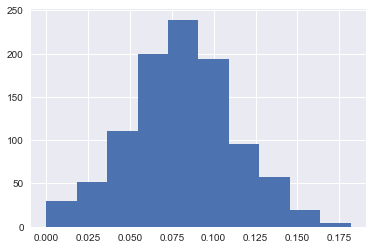

In [34]:
# Plot histogram of one of the variables
plt.hist(x[:,7])

#### Our initial state should reflect the 16849 addiction related deaths in 1999.

addiction-related death rate * addiction rate * population =  (mu star - mu)( addiction rate )* (320000000) = 16849

In [35]:
mu_star = 0.011
addiction_rate_0= (16849/320000000.)*(1/(mu_star-mu))
print mu_star, mu, addiction_rate_0

0.011 0.00824 0.0190772192029


### Plot the estimated number of deaths due to drug overdose over time (does not account for age, gender, etc.)

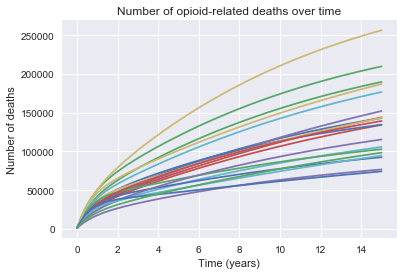

In [40]:
# times to solve at
t = np.linspace(0, 15, 150)

population_us = 320000000
# initial state
state0 = [0.78, 0.2, 0.0015, 0.005]

final_addiction_rate = []
# solve
for _ in range(20):
    x = np.random.multivariate_normal(mean, cov, 1)
    x[x>1] = 1
    x[x<0] = 0
    epsilon, xi, gamma, nu, sigma, delta, beta, alpha, zeta = x[0]
    numerical_sol = sp.integrate.odeint(opioid, state0, t, args=(alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))
    A = numerical_sol[:,2]
    final_addiction_rate.append(A[-1])

# plot
    #plt.plot(t, A) #, label="addicts"
    plt.plot(t, population_us*(mu_star-mu)*A)
    plt.xlabel("Time (years)")
    plt.ylabel("Number of deaths")
    plt.title("Number of opioid-related deaths over time")
#plt.ylim([0, 0.3])
plt.legend()

(array([ 2.,  5.,  1.,  6.,  1.,  1.,  2.,  1.,  0.,  1.]),
 array([ 0.08408601,  0.10469725,  0.12530848,  0.14591972,  0.16653096,
         0.18714219,  0.20775343,  0.22836466,  0.2489759 ,  0.26958714,
         0.29019837]),
 <a list of 10 Patch objects>)

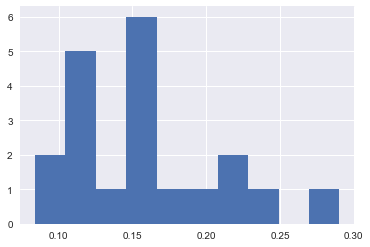

In [41]:
# Plot histogram of final addiction rate at equilibrium
plt.hist(final_addiction_rate)

### What will the long-term addiction rate be for various values of prescription rate and rehabilitation rates?

#### Vary alphas and zetas and plot a contour plot

0
10
20
30
40
50
60
70
80
90
100


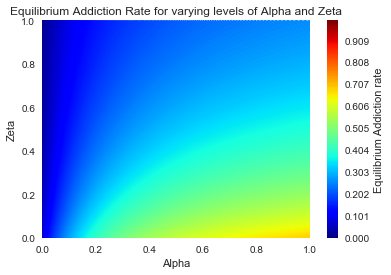

In [42]:
alphas = np.linspace(0,1,num=101)
zetas = np.linspace(0,1,num=101)
X, Y = np.meshgrid(alphas, zetas)
Z = np.empty(X.shape)

state0 = [0.87, 0.1, 0.02, 0.01] # initial state
t = np.linspace(0, 15, 1501) # 15 years
for i in range(X.shape[0]):
    if i%10==0: print i
    for j in range(X.shape[0]):
        alpha = X[i,j]
        zeta = Y[i,j]
        # for a given value of alpha and zeta, solve the initial value problem
        numerical_sol = sp.integrate.odeint(opioid, state0, t, args=(alpha, epsilon, beta, xi, gamma, zeta, delta, nu, sigma, mu, mu_star))
        Z[i,j] = numerical_sol[-1,2] # final state for addicts
plt.contour(X, Y, Z, cmap=plt.cm.jet,levels=np.linspace(0,1,num=1001)  )
plt.colorbar(label="Equilibrium Addiction rate")
plt.title("Equilibrium Addiction Rate for varying levels of Alpha and Zeta")
plt.xlabel("Alpha")
plt.ylabel("Zeta")

## Data exploration


### Import drug-related deaths data

In [43]:
data = pd.read_csv('NCHS_-_Drug_Poisoning_Mortality_by_State__United_States (1).csv')
data.columns = [u'Year', u'Sex', u'Age', u'Race', u'State', 
                u'Deaths', u'Population', u'Crude Death Rate', 
                u'Standard Error for Crude Rate', u'Low Confidence Limit for Crude Rate', 
                u'Upper Confidence Limit for Crude Rate', u'Age-adjusted Rate', 
                u'Standard Error Age-adjusted Rate', 
                u'Lower Confidence Limit for Age-adjusted rate', 
                u'Upper Confidence Limit for Age-adjusted Rate', 
                u'State Crude Rate in Range', u'US Crude Rate', 
                u'US Age-adjusted Rate']

In [44]:
data = data.query('Age== "All Ages" & Sex=="Both Sexes" & Race=="All Races-All Origins" & State!="United States"')

In [45]:
data['Deaths'] = data['Deaths'].apply(lambda x: x.replace(',',''))
data['Deaths'] = pd.to_numeric(data['Deaths'], errors='coerce')
data['Population'] = data['Population'].apply(lambda x: x.replace(',',''))
data['Population'] = pd.to_numeric(data['Population'], errors='coerce')
data['Age-adjusted Rate'] = data['Age-adjusted Rate']*data['Population']/100000
result = data.groupby(['Year'])['Deaths'].sum()
result = result.reset_index()

In [46]:
data['State'].unique().shape

(51,)

In [47]:
A_2014 = 2000000.
deaths_2014 = result[result['Year']==2014]['Deaths'].values[0]
deaths_2014/A_2014

0.0235275

In [48]:
result[result['Year']==1999]['Deaths'].values[0]

16849

### Plot total number of opioid-related deaths per year

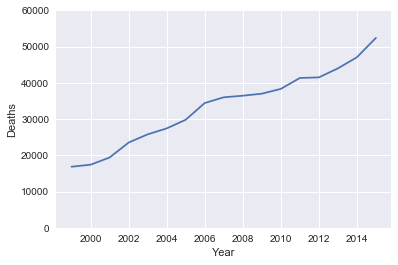

In [49]:
plt.plot(result['Year'],result['Deaths'])
plt.ylim([0,60000])
plt.xlabel("Year")
plt.ylabel("Deaths")

### County level exploration

In [50]:
data = pd.read_csv('NCHS_-_Drug_Poisoning_Mortality_by_County__United_States (1).csv')
split = data['Estimated Age-adjusted Death Rate, 16 Categories (in ranges)'].apply(lambda x: x.split('-'))
split['lower'] = split.apply(lambda x: x[0])
def getUpper(x):
    try:
        return x[1]
    except: return x[0]
split['upper'] = split.apply(getUpper)

In [51]:
data['lower'] = pd.to_numeric(split['lower'], errors='coerce')
data['lower'] = data['lower']*data['Population']/100000
data['upper'] = pd.to_numeric(split['upper'], errors='coerce')
data['upper'] = data['upper']*data['Population']/100000
result = data.groupby(['Year'])['upper'].sum()
result = result.reset_index()

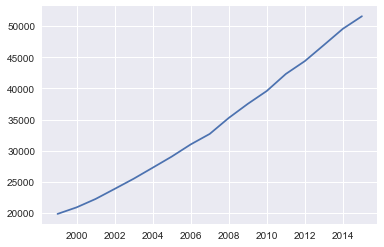

In [52]:
plt.plot(result['Year'],result['upper'])

## Explore prescription data
How can we incorporate this data into the model?

In [53]:
# Import data
prescription_rate = pd.read_csv('opioid_prescription_data.csv')

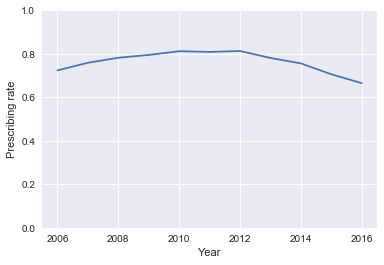

In [54]:
# Plot rate vs Year
plt.plot(prescription_rate['Year'], 0.01*prescription_rate['prescribing_rate_per_100_persons'])
plt.ylim([0,1])
plt.xlabel("Year")
plt.ylabel("Prescribing rate")